In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, optimizers
from keras.callbacks import EarlyStopping
# import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.layers import Reshape, Bidirectional, LSTM, Dense
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from commons import mean_absolute_percentage_error 
from keras.utils import to_categorical
# from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor
#regression metrics

#modules for plots if required
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot 

### Bitcoin

In [2]:
selected = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [3]:
btcData = btc[selected.columns]

In [4]:
btcData['returns'] = btcData['priceUSD'].pct_change().copy()

/tmp/ipykernel_182169/712760780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change().copy()


In [5]:
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [6]:
Data 

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [7]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然

In [8]:
Y

Date
2010-07-18    0.0678
2010-07-19    0.0690
2010-07-20    0.0673
2010-07-21    0.0661
2010-07-22    0.0660
               ...  
2022-11-24       NaN
2022-11-25       NaN
2022-11-26       NaN
2022-11-27       NaN
2022-11-28       NaN
Name: priceUSD, Length: 4517, dtype: float64

In [9]:
X.head(3)

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,162.138,164.162,100.0,173.723,20.555,838438881.0,1.757449e+17,0.0,0.0,401834.0,...,0.0,0,2612.0,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,162.138,164.162,100.0,173.723,22.486,881995244.0,1.944789e+17,0.0,0.0,481473.0,...,0.0,0,4047.0,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,158.406,164.162,100.0,173.557,24.414,928054231.0,2.153212e+17,0.0,0.0,431831.0,...,0.0,0,2341.0,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475


In [10]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [11]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [12]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [13]:
# X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
# X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
# Y_train=Y_train.values
# Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
# Y_val=Y_val.values
# Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
# Y_test=Y_test.values
# Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [14]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [15]:
# model = Sequential()
# model.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
# model.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
# model.add(Dense(1))
# model.compile(loss="logcosh", optimizer=adam, metrics=['mae'])
# earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

In [16]:
adam=optimizers.Adam(lr=lr_schedule(0),amsgrad=True)
def create_model(activation='relu', neurons_input = 350, neurons_hidden_1=1,
                optimizer=adam):

    model = Sequential()

    # Add this before LSTM. The tuple denotes the last two dimensions of input
    model.add(Reshape((1, X_train.shape[1])))
    model.add(Reshape((1, 1)))
    #same as
    # X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
    # Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
    model.add(Bidirectional(LSTM(neurons_input, 
                    activation=activation, 
                    return_sequences=True,
                    # Since the data is 2-D, the following needs to be changed from "X_train.shape[1], X_train.shape[2]"
                    input_shape=(1, X_train.shape[1]),
                    )))
    model.add(Bidirectional(LSTM(neurons_input, 
                    activation=activation, 
                    return_sequences=True,
                    # Since the data is 2-D, the following needs to be changed from "X_train.shape[1], X_train.shape[2]"
                    )))

    model.add(Dense(1))

    model.compile(loss = 'logcosh', optimizer=optimizer)
    return model

Learning rate:  0.001


# R2 OOS

In [17]:
# R_square_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

r2oos_score = make_scorer(r2_oos, greater_is_better=True)  

In [18]:
# Stop training when a monitored metric has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')
# regressor = create_model()
# regressor.fit(X_train,Y_train, epochs=5000, batch_size=32, validation_data=(X_val,Y_val), callbacks=[earlyStopping])

In [19]:
regressor=KerasRegressor(build_fn=create_model,epochs=5000,verbose=1)

param_grid = {
    'activation': ['relu', 'tanh'],
    'neurons_input':   [250, 300, 350, 400],
    'batch_size': [40,60,80,100]}

len_X_train = len(X_train)
len_X_val = len(X_val)
val_fold = np.repeat([-1, 0], [len_X_train, len_X_val])
ps = PredefinedSplit(val_fold)

X_train_n_val = np.vstack((X_train, X_val))
y_train_n_val = pd.concat([Y_train, Y_val]).values

# use two scorer:r2oos and mse 
scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}
grid = RandomizedSearchCV(regressor, param_grid, cv=ps, n_jobs=8, n_iter=15, verbose=2, scoring= scoring_dict, refit ='r2_oos') #could try n_iter=60 for better result

grid.fit(X_train_n_val, y_train_n_val)

Fitting 1 folds for each of 15 candidates, totalling 15 fits


2022-12-01 22:23:05.108761: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.109396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 22:23:05.109663: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2022-12-01 22:23:05.208308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-01 22:23:05.208707: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2804000000 Hz


Epoch 1/5000


2022-12-01 22:23:05.329562: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.329940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 22:23:05.330205: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2022-12-01 22:23:05.335029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.335711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library 

Epoch 1/5000
Epoch 1/5000
[CV] END ..activation=relu, batch_size=80, neurons_input=400; total time=   0.5s
[CV] END ..activation=relu, batch_size=60, neurons_input=300; total time=   0.3s


2022-12-01 22:23:05.580304: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.581282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 22:23:05.581750: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2022-12-01 22:23:05.649691: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.650025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library 

[CV] END ..activation=tanh, batch_size=40, neurons_input=300; total time=   0.4s
Epoch 1/5000
Epoch 1/5000
Epoch 1/5000
Epoch 1/5000


2022-12-01 22:23:05.823005: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.823358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 22:23:05.823677: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2022-12-01 22:23:05.869694: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 22:23:05.870259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library 

[CV] END .activation=relu, batch_size=100, neurons_input=300; total time=   0.4s
Epoch 1/5000
Epoch 1/5000
[CV] END ..activation=relu, batch_size=60, neurons_input=400; total time=   0.5s


2022-12-01 22:23:06.101269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-01 22:23:06.102286: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2804000000 Hz
2022-12-01 22:23:06.150623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-01 22:23:06.151079: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2804000000 Hz


Epoch 1/5000
[CV] END ..activation=relu, batch_size=40, neurons_input=350; total time=   0.4s
[CV] END ..activation=tanh, batch_size=80, neurons_input=400; total time=   0.4s
Epoch 1/5000
[CV] END .activation=relu, batch_size=100, neurons_input=350; total time=   0.5s
Epoch 1/5000
Epoch 1/5000
[CV] END ..activation=relu, batch_size=80, neurons_input=300; total time=   0.3s
[CV] END ..activation=relu, batch_size=60, neurons_input=350; total time=   0.5s
Epoch 1/5000
[CV] END ..activation=relu, batch_size=40, neurons_input=400; total time=   0.5s
Epoch 1/5000
[CV] END .activation=tanh, batch_size=100, neurons_input=400; total time=   0.4s
[CV] END ..activation=tanh, batch_size=40, neurons_input=350; total time=   0.4s
[CV] END ..activation=tanh, batch_size=60, neurons_input=400; total time=   0.8s
[CV] END .activation=relu, batch_size=100, neurons_input=400; total time=   0.3s


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3361, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3196, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 990, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 634, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 977, in wrapper
    raise e.ag_error_metadata.to_exception(e)
NotImplementedError: in user code:

    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:539 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:652 call
        y = self.forward_layer(forward_inputs,
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:642 get_initial_state
        init_state = get_initial_state_fn(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2506 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3088 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential/bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3361, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3196, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 990, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 634, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 977, in wrapper
    raise e.ag_error_metadata.to_exception(e)
NotImplementedError: in user code:

    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:539 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:652 call
        y = self.forward_layer(forward_inputs,
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:642 get_initial_state
        init_state = get_initial_state_fn(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2506 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3088 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_1/bidirectional_2/forward_lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3361, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3196, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 990, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 634, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
  File "/home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 977, in wrapper
    raise e.ag_error_metadata.to_exception(e)
NotImplementedError: in user code:

    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:539 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/wrappers.py:652 call
        y = self.forward_layer(forward_inputs,
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:642 get_initial_state
        init_state = get_initial_state_fn(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2506 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3088 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /home/spectre/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/spectre/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_2/bidirectional_4/forward_lstm_4/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported



In [ ]:
y_val_pred=grid.predict(X_val)
# y_val_pred=regressor.predict(X_val)

AttributeError: 'KerasRegressor' object has no attribute 'model'

In [ ]:
# r2_oos 
pred_r2_score = r2_oos(Y_val, y_val_pred)

NameError: name 'y_val_pred' is not defined

In [ ]:
# y_pred=regressor.predict(X_test)
y_pred=grid.predict(X_test)
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

546/546 [==============================] - 0s 83us/step


,y_test,y_pred
Date,,
2021-06-01,33731.0,34394.320312
2021-06-02,33285.0,34062.855469
2021-06-03,34298.0,33482.195312
2021-06-04,35271.0,34105.074219
2021-06-05,34100.0,33992.710938
...,...,...
2022-11-24,NaN,24159.792969
2022-11-25,NaN,23844.636719
2022-11-26,NaN,23678.773438


In [ ]:
r2=r2_score(Y_test[0:-30],y_pred[0:-30]) #testing score/ r^2
r2

0.528306537077153

In [ ]:
rmse=np.sqrt(mean_squared_error(Y_test[0:-30],y_pred[0:-30])) #rmse
rmse

9293.30533975775

In [ ]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [ ]:
pre_df

,y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,34394.320312,NaN
2021-06-02,33285.0,34062.855469,-0.009637
2021-06-03,34298.0,33482.195312,-0.017047
2021-06-04,35271.0,34105.074219,0.018603
2021-06-05,34100.0,33992.710938,-0.003295
...,...,...,...
2022-11-24,NaN,24159.792969,-0.012123
2022-11-25,NaN,23844.636719,-0.013045
2022-11-26,NaN,23678.773438,-0.006956


<AxesSubplot:>

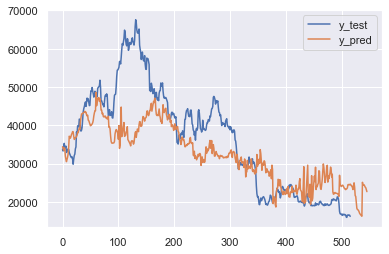

In [ ]:
pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred']).plot()

In [ ]:
pre_df.to_csv("btc_NN.csv")